# Data Processing

In this step, we will split the data, then augment the part of the training data to make the model more robust. The testings data will stay unaltered to avoid any bias.

## Splitting the Data

The first phase is to split the data into training and validation sets. We will use the training data to train the model and the validation data to evaluate the model's performance. We will use 80% of the data for training and 20% for testing.

In [ ]:
import os
import random
import shutil
from pathlib import Path

def restructure_dataset(raw_dir, restructured_dir, test_ratio=0.2, val_ratio=0.1):
    """
    Restructure the raw dataset into training, validation, and testing sets with separate images and labels directories.

    Args:
        raw_dir (str): Path to the raw dataset containing subfolders for each category.
        restructured_dir (str): Path to the restructured dataset.
        test_ratio (float): Proportion of data to allocate to the testing set.
        val_ratio (float): Proportion of data to allocate to the validation set.
    """
    raw_path = Path(raw_dir)
    restructured_path = Path(restructured_dir)
    categories = [d for d in raw_path.iterdir() if d.is_dir()]

    # Create directories for training, validation, and testing
    dirs = {
        "training": (restructured_path / "training/images", restructured_path / "training/labels"),
        "validation": (restructured_path / "validation/images", restructured_path / "validation/labels"),
        "testing": (restructured_path / "testing/images", restructured_path / "testing/labels")
    }

    for image_dir, label_dir in dirs.values():
        print(f"Creating directories: {image_dir}, {label_dir}")
        image_dir.mkdir(parents=True, exist_ok=True)
        label_dir.mkdir(parents=True, exist_ok=True)

    # Process each category
    for category in categories:
        print(f"Processing: {category.name}")

        # Get all image-label pairs
        files = sorted(category.glob("*.jpg"))
        label_files = {f.stem: f for f in category.glob("*.txt")}

        image_label_pairs = [
            (image_file, label_files[image_file.stem])
            for image_file in files if image_file.stem in label_files
        ]

        # Shuffle and split data
        random.shuffle(image_label_pairs)
        total_count = len(image_label_pairs)
        test_count = int(total_count * test_ratio)
        val_count = int(total_count * val_ratio)

        testing_pairs = image_label_pairs[:test_count]
        validation_pairs = image_label_pairs[test_count:test_count + val_count]
        training_pairs = image_label_pairs[test_count + val_count:]

        # Function to copy files to target directories
        def copy_files(pairs, image_dir, label_dir):
            for img, lbl in pairs:
                shutil.copy(img, image_dir / img.name)
                shutil.copy(lbl, label_dir / lbl.name)

        # Move files to respective directories
        copy_files(training_pairs, *dirs["training"])
        copy_files(validation_pairs, *dirs["validation"])
        copy_files(testing_pairs, *dirs["testing"])

    print(f"Dataset restructuring complete. Data saved to {restructured_path}")

In [84]:
import os

raw_directory = "./datasets/raw/raw"
restructured_directory = "./datasets/processed_split"
test_ratio = 0.2
val_ratio = 0.1

# Clear the restructured directory
if os.path.exists(restructured_directory):
    shutil.rmtree(restructured_directory)

restructure_dataset(raw_directory, restructured_directory, test_ratio, val_ratio)

Creating directories: datasets/processed_split/training/images, datasets/processed_split/training/labels
Creating directories: datasets/processed_split/validation/images, datasets/processed_split/validation/labels
Creating directories: datasets/processed_split/testing/images, datasets/processed_split/testing/labels
Processing: pituitary
Processing: notumor
Processing: glioma
Processing: meningioma
Dataset restructuring complete. Data saved to datasets/processed_split


## Augmenting the Data
In this step, we will apply multiple augmentation techniques to the training data to make the model more robust. We will use the following ones:
- **Geometric Transformations**: Random rotations, translations, and scaling to simulate different perspectives while carefully avoiding misrepresentation of tumor regions.
- **Intensity Augmentation**: Adjustments to contrast and noise injection to mimic varying MRI quality. Although the dataset includes images from modalities beyond MRI, these augmentations remain useful for improving robustness.
- **Elastic Deformations**: Non-linear transformations to simulate anatomical variability, helping the model generalise to diverse patient anatomies.

### Geometric Transformations

Here wil apply random rotations, translations, and scaling to simulate different perspectives while carefully avoiding misrepresentation of tumor regions.

#### Geometric Transformations - Implementation

Now we implement the basic geometric transformations.

In [93]:
import os
import cv2
import numpy as np
from pathlib import Path
import shutil

class GeometricAugmenter:
    def __init__(self, processed_dir, augmented_dir, subsample_percent=1.0):
        """
        Initialize the augmenter with processed and augmented directories.
        
        Args:
            processed_dir (str): Path to processed directory containing train/test splits
            augmented_dir (str): Path to target directory for augmented data
            subsample_percent (float): Percentage of files to augment
        """
        self.processed_dir = Path(processed_dir)
        self.augmented_dir = Path(augmented_dir)
        self.subsample_percent = subsample_percent
        
        # Create directory structure for augmented data
        for split in ['training', 'testing']:
            os.makedirs(self.augmented_dir / split / 'images', exist_ok=True)
            os.makedirs(self.augmented_dir / split / 'labels', exist_ok=True)
    
    def transform_bbox(self, bbox, transformation_matrix, image_shape):
        """
        Transform bounding box coordinates using the transformation matrix.
        
        Args:
            bbox (list): [x_center, y_center, width, height] normalized coordinates
            transformation_matrix (np.array): 3x3 transformation matrix
            image_shape (tuple): (height, width) of the image
            
        Returns:
            list: Transformed normalized coordinates [x_center, y_center, width, height]
        """
        height, width = image_shape
        # Convert normalized to absolute coordinates
        x_center, y_center = bbox[0] * width, bbox[1] * height
        box_width, box_height = bbox[2] * width, bbox[3] * height
        
        # Get corner points
        x1 = x_center - box_width/2
        y1 = y_center - box_height/2
        x2 = x_center + box_width/2
        y2 = y_center + box_height/2
        
        # Transform corners
        points = np.array([[x1, y1, 1],
                          [x2, y1, 1],
                          [x2, y2, 1],
                          [x1, y2, 1]])
        transformed_points = np.dot(points, transformation_matrix.T)
        
        # Normalize homogeneous coordinates
        transformed_points = transformed_points[:, :2] / transformed_points[:, 2:]
        
        # Get new bbox parameters
        min_x = np.min(transformed_points[:, 0])
        max_x = np.max(transformed_points[:, 0])
        min_y = np.min(transformed_points[:, 1])
        max_y = np.max(transformed_points[:, 1])
        
        # Convert back to center format and normalize
        new_center_x = (min_x + max_x) / 2 / width
        new_center_y = (min_y + max_y) / 2 / height
        new_width = (max_x - min_x) / width
        new_height = (max_y - min_y) / height
        
        # Clip values to [0, 1]
        new_center_x = np.clip(new_center_x, 0, 1)
        new_center_y = np.clip(new_center_y, 0, 1)
        new_width = np.clip(new_width, 0, 1)
        new_height = np.clip(new_height, 0, 1)
        
        return [new_center_x, new_center_y, new_width, new_height]

    def rotate_image(self, image_path, label_path, angle):
        """Rotate image and its bounding box by given angle."""
        image = cv2.imread(str(image_path))
        height, width = image.shape[:2]
        
        # Get rotation matrix
        center = (width/2, height/2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotation_matrix = np.vstack([rotation_matrix, [0, 0, 1]]).astype(np.float32)
        
        # Rotate image
        rotated_image = cv2.warpPerspective(image, rotation_matrix, (width, height))
        
        # Transform bounding box
        transformed_bbox = None
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                line = f.readline().strip().split()
                if len(line) >= 5:
                    class_id = int(line[0])
                    bbox = list(map(float, line[1:]))
                    transformed_bbox = [class_id] + self.transform_bbox(bbox, rotation_matrix, (height, width))
        
        return rotated_image, transformed_bbox

    def translate_image(self, image_path, label_path, dx, dy):
        """Translate image and its bounding box."""
        image = cv2.imread(str(image_path))
        height, width = image.shape[:2]
        
        # Convert relative translations to pixels
        dx_pixels = int(dx * width)
        dy_pixels = int(dy * height)
        
        # Create translation matrix
        translation_matrix = np.array([
            [1, 0, dx_pixels],
            [0, 1, dy_pixels],
            [0, 0, 1]
        ], dtype=np.float32)
        
        # Translate image
        translated_image = cv2.warpPerspective(image, translation_matrix, (width, height))
        
        # Transform bounding box
        transformed_bbox = None
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                line = f.readline().strip().split()
                if len(line) >= 5:
                    class_id = int(line[0])
                    bbox = list(map(float, line[1:]))
                    transformed_bbox = [class_id] + self.transform_bbox(bbox, translation_matrix, (height, width))
        
        return translated_image, transformed_bbox

    def scale_image(self, image_path, label_path, scale_factor):
        """Scale image and its bounding box."""
        image = cv2.imread(str(image_path))
        height, width = image.shape[:2]
        
        # Create scaling matrix
        scaling_matrix = np.array([
            [scale_factor, 0, width*(1-scale_factor)/2],
            [0, scale_factor, height*(1-scale_factor)/2],
            [0, 0, 1]
        ], dtype=np.float32)
        
        # Scale image
        scaled_image = cv2.warpPerspective(image, scaling_matrix, (width, height))
        
        # Transform bounding box
        transformed_bbox = None
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                line = f.readline().strip().split()
                if len(line) >= 5:
                    class_id = int(line[0])
                    bbox = list(map(float, line[1:]))
                    transformed_bbox = [class_id] + self.transform_bbox(bbox, scaling_matrix, (height, width))
        
        return scaled_image, transformed_bbox

    def apply_augmentations(self, split='training'):
        """
        Apply geometric augmentations to images in specified split.
        
        Args:
            split (str): 'training' or 'testing'
        """
        source_img_dir = self.processed_dir / split / 'images'
        source_label_dir = self.processed_dir / split / 'labels'
        target_img_dir = self.augmented_dir / split / 'images'
        target_label_dir = self.augmented_dir / split / 'labels'
        
        # First copy original files
        if not target_img_dir.exists() or not target_label_dir.exists():
            target_img_dir.mkdir(parents=True, exist_ok=True)
            target_label_dir.mkdir(parents=True, exist_ok=True)
        for file_path in source_img_dir.glob('*.jpg'):
            shutil.copy2(file_path, target_img_dir)
            label_path = source_label_dir / f"{file_path.stem}.txt"
            if label_path.exists():
                shutil.copy2(label_path, target_label_dir)
        
        # Apply augmentations only to training set
        if split == 'training':
            # If subsampling is enabled, randomly select files to augment
            files_to_augment = list(source_img_dir.glob('*.jpg'))
            if self.subsample_percent < 1.0:
                num_files = len(files_to_augment)
                num_files_to_augment = int(num_files * self.subsample_percent)
                files_to_augment = random.sample(files_to_augment, num_files_to_augment)
                print(f"Subsampling {num_files_to_augment}/{num_files} files for augmentation")
            for image_path in files_to_augment:
                base_name = image_path.stem
                label_path = source_label_dir / f"{base_name}.txt"
                
                # Rotation augmentations
                for angle in [90, 180, 270]:
                    aug_name = f"{base_name}_rot{angle}"
                    if os.path.exists(target_label_dir / f"{aug_name}.txt"):
                        continue
                    aug_image, aug_bbox = self.rotate_image(image_path, label_path, angle)
                    if aug_bbox is not None:
                        cv2.imwrite(str(target_img_dir / f"{aug_name}.jpg"), aug_image)
                        with open(target_label_dir / f"{aug_name}.txt", 'w') as f:
                            print(f"writting {aug_name}")
                            f.write(' '.join(map(str, aug_bbox)))
                
                # Translation augmentations
                for dx, dy in [(0.1, 0.1), (-0.1, 0.1), (0.1, -0.1), (-0.1, -0.1)]:
                    aug_image, aug_bbox = self.translate_image(image_path, label_path, dx, dy)
                    if aug_bbox is not None:
                        aug_name = f"{base_name}_trans_{int(dx*100)}_{int(dy*100)}"
                        cv2.imwrite(str(target_img_dir / f"{aug_name}.jpg"), aug_image)
                        with open(target_label_dir / f"{aug_name}.txt", 'w') as f:
                            f.write(' '.join(map(str, aug_bbox)))
                
                # Scaling augmentations
                for scale in [0.8, 1.2]:
                    aug_image, aug_bbox = self.scale_image(image_path, label_path, scale)
                    if aug_bbox is not None:
                        aug_name = f"{base_name}_scale_{int(scale*100)}"
                        cv2.imwrite(str(target_img_dir / f"{aug_name}.jpg"), aug_image)
                        with open(target_label_dir / f"{aug_name}.txt", 'w') as f:
                            f.write(' '.join(map(str, aug_bbox)))

    def delete_augmentations(self, split='training'):
        """
        Delete all augmented files from specified split, keeping only original files.
        
        Args:
            split (str): 'training' or 'testing'
        """
        target_img_dir = self.augmented_dir / split / 'images'
        target_label_dir = self.augmented_dir / split / 'labels'
        
        # Delete all files in target directories
        for file_path in target_img_dir.glob('*_rot*.jpg'):
            os.remove(file_path)
        for file_path in target_img_dir.glob('*_trans_*.jpg'):
            os.remove(file_path)
        for file_path in target_img_dir.glob('*_scale_*.jpg'):
            os.remove(file_path)
        for file_path in target_label_dir.glob('*_rot*.txt'):
            os.remove(file_path)
        for file_path in target_label_dir.glob('*_trans_*.txt'):
            os.remove(file_path)
        for file_path in target_label_dir.glob('*_scale_*.txt'):
            os.remove(file_path)

#### Geometric Transformations - Testing

It's crucial to test the geometric transformations to ensure that they are working as expected. We will apply the transformations to a sample image, assert and visualize the results to confirm that the transformations are working as expected.

In [69]:
import unittest
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import tempfile
import os

class TestGeometricAugmenter(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        """Create synthetic test data"""
        # Create temporary directory for test data
        cls.test_dir = tempfile.mkdtemp()
        cls.processed_dir = Path(cls.test_dir) / "processed_split"
        cls.augmented_dir = Path(cls.test_dir) / "augmented_split"
        
        # Create directory structure
        for split in ['training', 'testing']:
            os.makedirs(cls.processed_dir / split / 'images', exist_ok=True)
            os.makedirs(cls.processed_dir / split / 'labels', exist_ok=True)
        
        # Create synthetic test image (black rectangle on white background)
        cls.test_image = np.ones((100, 100, 3), dtype=np.uint8) * 255
        x1, y1, x2, y2 = 25, 25, 50, 75
        cv2.rectangle(cls.test_image, (x1, y1), (x2, y2), (0, 0, 0), -1)
        
        # Save test image and label
        center_x = (x1 + x2) / 2 / cls.test_image.shape[1]
        center_y = (y1 + y2) / 2 / cls.test_image.shape[0]
        width = (x2 - x1) / cls.test_image.shape[1]
        height = (y2 - y1) / cls.test_image.shape[0]
        cv2.imwrite(str(cls.processed_dir / "training" / "images" / "test.jpg"), cls.test_image)
        with open(cls.processed_dir / "training" / "labels" / "test.txt", 'w') as f:
            # Center coordinates (0.5, 0.5), width=height=0.5
            # f.write(f"0 0.25 0.5 0.25 0.5")
            f.write(f"0 {center_x} {center_y} {width} {height}")
        
        # Initialize augmenter
        cls.augmenter = GeometricAugmenter(cls.processed_dir, cls.augmented_dir)

    def read_bbox(self, label_path):
        """Helper function to read bbox from label file"""
        with open(label_path, 'r') as f:
            line = f.readline().strip().split()
            return [float(x) for x in line]  # Returns [class_id, x, y, w, h]

    def visualize_transformation(self, original_img, transformed_img, original_bbox, transformed_bbox, title):
        """Helper function to visualize transformation results"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        
        # Plot original
        ax1.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        if original_bbox is not None:
            self.plot_bbox(ax1, original_bbox, original_img.shape[:2])
        ax1.set_title('Original')
        
        # Plot transformed
        ax2.imshow(cv2.cvtColor(transformed_img, cv2.COLOR_BGR2RGB))
        if transformed_bbox is not None:
            self.plot_bbox(ax2, transformed_bbox, transformed_img.shape[:2])
        ax2.set_title('Transformed')
        
        plt.suptitle(title)
        plt.show()
    
    def plot_bbox(self, ax, bbox, img_shape):
        """Helper function to plot bounding box"""
        if bbox is None or len(bbox) < 5:
            return
        
        height, width = img_shape
        _, x_center, y_center, box_width, box_height = bbox
        
        x_center = float(x_center) * width
        y_center = float(y_center) * height
        box_width = float(box_width) * width
        box_height = float(box_height) * height
        
        x1 = x_center - box_width/2
        y1 = y_center - box_height/2
        
        rect = plt.Rectangle((x1, y1), box_width, box_height,
                           fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
    
    def test_rotation(self):
        """Test rotations (90, 180 & 270 degrees)"""
        img_path = self.processed_dir / "training" / "images" / "test.jpg"
        label_path = self.processed_dir / "training" / "labels" / "test.txt"
        
        rotations = [90, 180, 270]
        # Read original bbox
        original_bbox = self.read_bbox(label_path)
        
        # Apply rotations
        for rotation in rotations:
            rotated_img, rotated_bbox = self.augmenter.rotate_image(img_path, label_path, rotation)
            
            # Visualize
            self.visualize_transformation(self.test_image, rotated_img, 
                                        original_bbox, rotated_bbox, 
                                        f"{rotation}-degree Rotation Test")
            
            # Assert bbox center is transformed correctly
            if rotation == 90:
                self.assertAlmostEqual(rotated_bbox[1], 0.5, places=2)
                self.assertAlmostEqual(rotated_bbox[2], 0.625, places=2)
                self.assertAlmostEqual(rotated_bbox[3], 0.5, places=2)
                self.assertAlmostEqual(rotated_bbox[4], 0.25, places=2)
            elif rotation == 180:
                self.assertAlmostEqual(rotated_bbox[1], 0.625, places=2)
                self.assertAlmostEqual(rotated_bbox[2], 0.5, places=2)
                self.assertAlmostEqual(rotated_bbox[3], 0.25, places=2)
                self.assertAlmostEqual(rotated_bbox[4], 0.5, places=2)
            elif rotation == 270:
                self.assertAlmostEqual(rotated_bbox[1], 0.5, places=2)
                self.assertAlmostEqual(rotated_bbox[2], 0.375, places=2)
                self.assertAlmostEqual(rotated_bbox[3], 0.5, places=2)
                self.assertAlmostEqual(rotated_bbox[4], 0.25, places=2)
            
    
    def test_translation(self):
        """Test translation"""
        img_path = self.processed_dir / "training" / "images" / "test.jpg"
        label_path = self.processed_dir / "training" / "labels" / "test.txt"
        
        # Read original bbox
        original_bbox = self.read_bbox(label_path)
        
        # Apply translations
        translations = [
            (0.1, 0.1), (-0.1, 0.1), (0.1, -0.1), (-0.1, -0.1)
        ]
        for translation in translations:
            dx, dy = translation
            translated_img, translated_bbox = self.augmenter.translate_image(img_path, label_path, dx, dy)
            
            # Visualize
            self.visualize_transformation(self.test_image, translated_img,
                                        original_bbox, translated_bbox,
                                        f"Translation Test (dx={dx}, dy={dy})")
            
            
            # Assert bbox is translated correctly
            print(original_bbox)
            print(translated_bbox)
            self.assertAlmostEqual(translated_bbox[1], original_bbox[1] + dx, places=2)  # new x center should be old x + translation
            self.assertAlmostEqual(translated_bbox[2], original_bbox[2] + dy, places=2)  # new y center should be old y + translation
    
    def test_scaling(self):
        """Test scaling"""
        img_path = self.processed_dir / "training" / "images" / "test.jpg"
        label_path = self.processed_dir / "training" / "labels" / "test.txt"
        
        # Read original bbox
        original_bbox = self.read_bbox(label_path)
        
        # Apply scaling
        scale = 1.5
        scaled_img, scaled_bbox = self.augmenter.scale_image(img_path, label_path, scale)
        
        # Visualize
        self.visualize_transformation(self.test_image, scaled_img,
                                    original_bbox, scaled_bbox,
                                    f"Scaling Test (scale={scale})")
        
        # Assert bbox size is scaled correctly
        self.assertAlmostEqual(scaled_bbox[3], original_bbox[3] * scale, places=2) # width should be scaled
        self.assertAlmostEqual(scaled_bbox[4], original_bbox[4] * scale, places=2) # height should be scaled

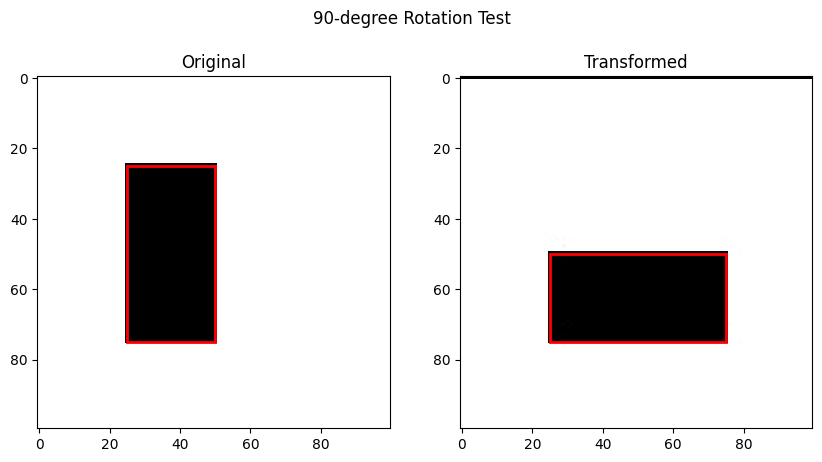

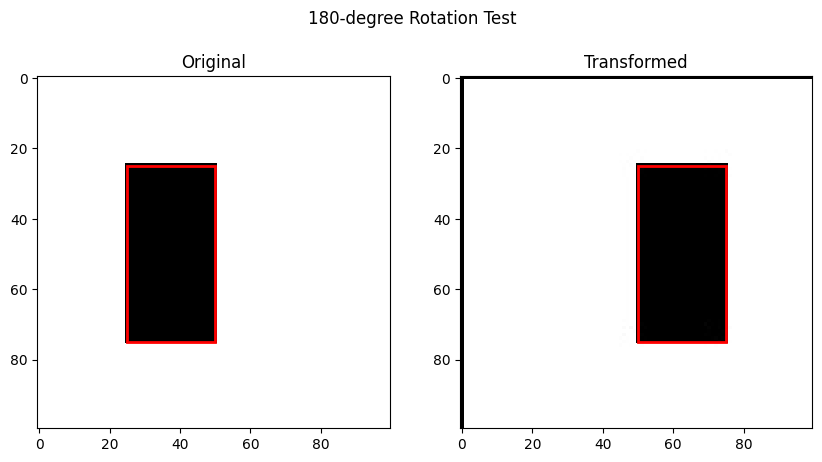

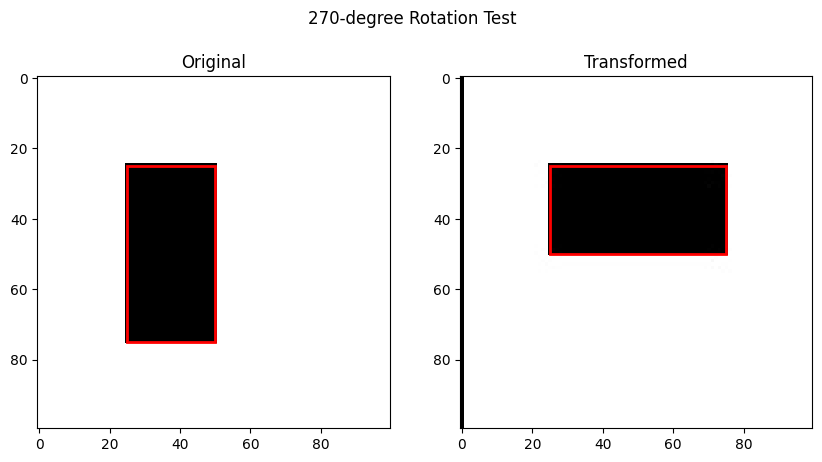

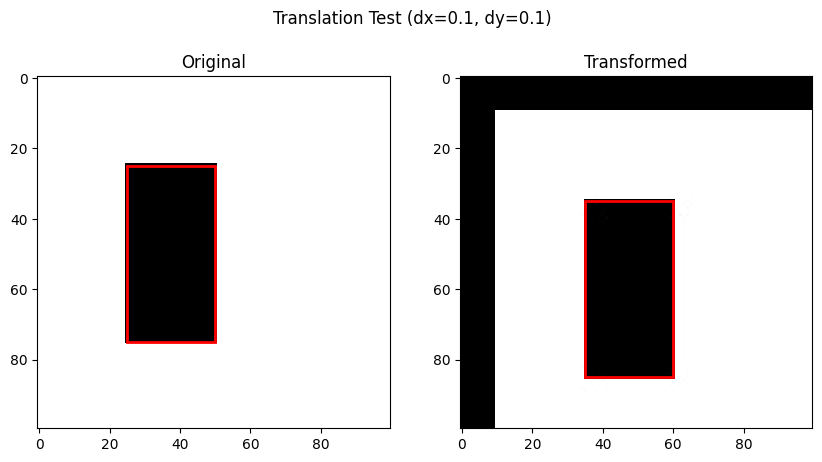

[0.0, 0.375, 0.5, 0.25, 0.5]
[0.0, 0.475, 0.6, 0.25, 0.5]


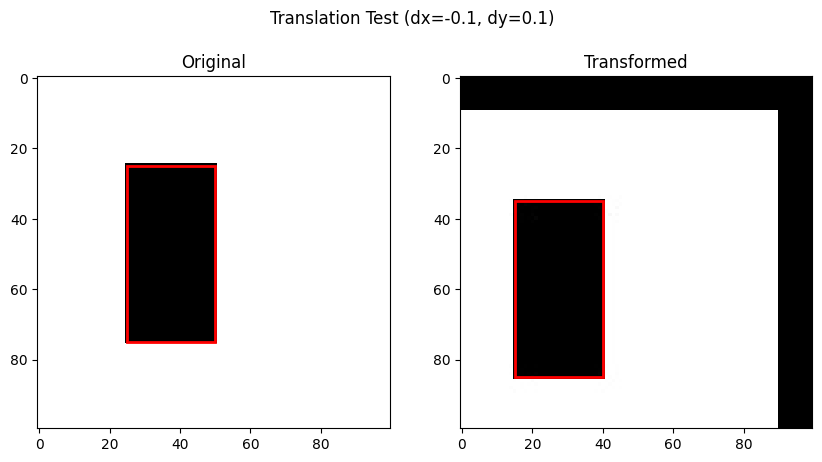

[0.0, 0.375, 0.5, 0.25, 0.5]
[0.0, 0.275, 0.6, 0.25, 0.5]


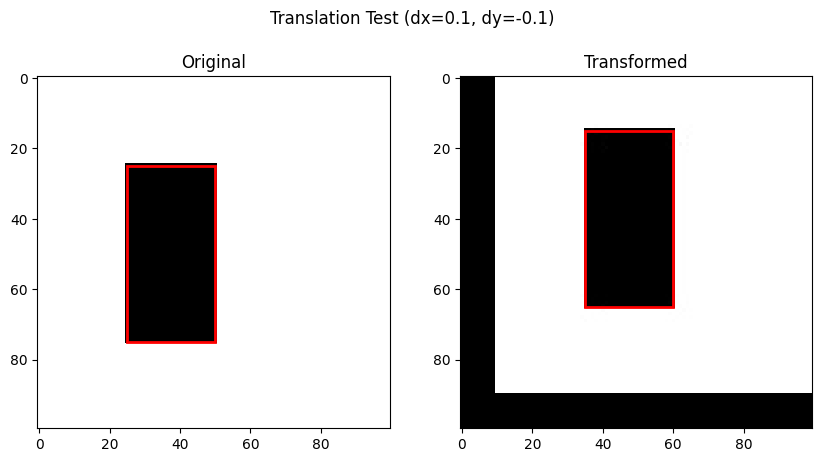

[0.0, 0.375, 0.5, 0.25, 0.5]
[0.0, 0.475, 0.4, 0.25, 0.5]


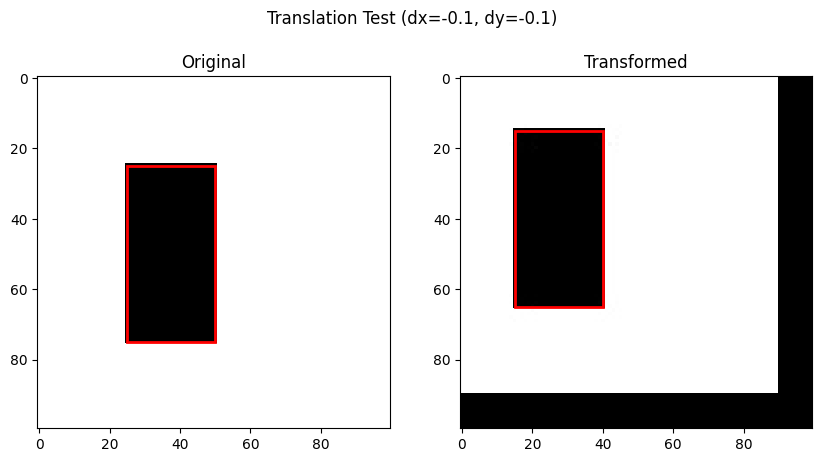

[0.0, 0.375, 0.5, 0.25, 0.5]
[0.0, 0.275, 0.4, 0.25, 0.5]


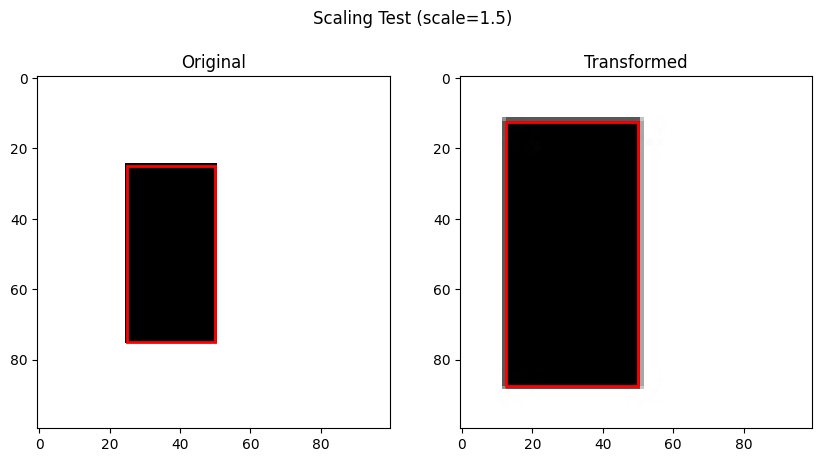

In [70]:
object_pos = [25, 25, 50, 75]
bounding_box_pos = [0, 0.25, 0.5, 0.25, 0.5]

test_case = TestGeometricAugmenter()
test_case.setUpClass()
test_case.test_rotation()
test_case.test_translation()
test_case.test_scaling()

#### Geometry Transformations - Apply

We now apply the various geometric transformations and add them to the **training data**.

In [95]:
source_dir = "./datasets/processed_split/"
target_dir = "./datasets/processed_augmented/"

subsampling_percent = 0.2
augmenter = GeometricAugmenter(source_dir, target_dir, subsample_percent=subsampling_percent)

# Delete all augmented files
augmenter.delete_augmentations(split='training')
augmenter.delete_augmentations(split='testing')
augmenter.delete_augmentations(split='validation')
# This will only copy the original files to the testing & validation directory
augmenter.apply_augmentations(split='testing')
augmenter.apply_augmentations(split='validation')
# Apply augmentations to training set
augmenter.apply_augmentations(split='training')

Subsampling 304/1523 files for augmentation
writting Tr-no_0257_rot90
writting Tr-no_0257_rot180
writting Tr-no_0257_rot270
writting Tr-gl_0210_rot90
writting Tr-gl_0210_rot180
writting Tr-gl_0210_rot270
writting Tr-gl_0310_rot90
writting Tr-gl_0310_rot180
writting Tr-gl_0310_rot270
writting Tr-no_0433_rot90
writting Tr-no_0433_rot180
writting Tr-no_0433_rot270
writting Tr-gl_0064_rot90
writting Tr-gl_0064_rot180
writting Tr-gl_0064_rot270
writting Tr-me_0468_rot90
writting Tr-me_0468_rot180
writting Tr-me_0468_rot270
writting Tr-gl_0405_rot90
writting Tr-gl_0405_rot180
writting Tr-gl_0405_rot270
writting Tr-gl_0336_rot90
writting Tr-gl_0336_rot180
writting Tr-gl_0336_rot270
writting Tr-pi_0202_rot90
writting Tr-pi_0202_rot180
writting Tr-pi_0202_rot270
writting Tr-me_0428_rot90
writting Tr-me_0428_rot180
writting Tr-me_0428_rot270
writting Tr-me_0032_rot90
writting Tr-me_0032_rot180
writting Tr-me_0032_rot270
writting Tr-gl_0557_rot90
writting Tr-gl_0557_rot180
writting Tr-gl_0557_rot

### Intensity Augmentation - Implementation



In [90]:
import os
import cv2
import numpy as np
from pathlib import Path
import shutil

class IntensityAugmenter:
    def __init__(self, processed_dir, augmented_dir, subsample_percent=1.0):
        """
        Initialize the augmenter with processed and augmented directories.

        Args:
            processed_dir (str): Path to processed directory containing train/test splits
            augmented_dir (str): Path to target directory for augmented data
            subsample_percent (float): Percentage of images to augment
        """
        self.processed_dir = Path(processed_dir)
        self.augmented_dir = Path(augmented_dir)
        self.subsample_percent = subsample_percent

        # Create directory structure for augmented data
        for split in ['training', 'testing']:
            os.makedirs(self.augmented_dir / split / 'images', exist_ok=True)
            os.makedirs(self.augmented_dir / split / 'labels', exist_ok=True)

    def adjust_contrast(self, image, alpha):
        """
        Adjust the contrast of the image.

        Args:
            image (np.array): Input image
            alpha (float): Contrast factor (>1 increases contrast, <1 decreases contrast)

        Returns:
            np.array: Contrast-adjusted image
        """
        return cv2.convertScaleAbs(image, alpha=alpha, beta=0)

    def inject_noise(self, image, mean=0, std=10):
        """
        Add Gaussian noise to the image.

        Args:
            image (np.array): Input image
            mean (float): Mean of the Gaussian noise
            std (float): Standard deviation of the Gaussian noise

        Returns:
            np.array: Image with added noise
        """
        noise = np.random.normal(mean, std, image.shape).astype(np.float32)
        noisy_image = cv2.add(image.astype(np.float32), noise)
        return np.clip(noisy_image, 0, 255).astype(np.uint8)

    def apply_augmentations(self, split='training'):
        """
        Apply intensity augmentations to images in the specified split.

        Args:
            split (str): 'training' or 'testing'
        """
        source_img_dir = self.processed_dir / split / 'images'
        source_label_dir = self.processed_dir / split / 'labels'
        target_img_dir = self.augmented_dir / split / 'images'
        target_label_dir = self.augmented_dir / split / 'labels'

        # First copy original files
        if not target_img_dir.exists() or not target_label_dir.exists():
            target_img_dir.mkdir(parents=True, exist_ok=True)
            target_label_dir.mkdir(parents=True, exist_ok=True)
        for file_path in source_img_dir.glob('*.jpg'):
            shutil.copy2(file_path, target_img_dir)
            label_path = source_label_dir / f"{file_path.stem}.txt"
            if label_path.exists():
                shutil.copy2(label_path, target_label_dir)

        # Apply augmentations only to training set
        if split == 'training':
            # If subsampling is enabled, randomly select files to augment
            files_to_augment = list(source_img_dir.glob('*.jpg'))
            if self.subsample_percent < 1.0:
                num_files = len(files_to_augment)
                num_files_to_augment = int(num_files * self.subsample_percent)
                files_to_augment = random.sample(files_to_augment, num_files_to_augment)
                print(f"Subsampling {num_files_to_augment}/{num_files} files for augmentation")
            for image_path in files_to_augment:
                base_name = image_path.stem
                label_path = source_label_dir / f"{base_name}.txt"

                # Load the image
                image = cv2.imread(str(image_path))

                # Contrast augmentations
                for alpha in [0.5, 1.5]:
                    aug_name = f"{base_name}_contrast_{int(alpha * 100)}"
                    aug_image = self.adjust_contrast(image, alpha)
                    file_name = str(target_img_dir / f"{aug_name}.jpg")
                    cv2.imwrite(file_name, aug_image)
                    print(f"writing {file_name}")
                    if label_path.exists():
                        shutil.copy2(label_path, target_label_dir / f"{aug_name}.txt")

                # Noise augmentations
                for std in [15, 30]:
                    aug_name = f"{base_name}_noise_{std}"
                    aug_image = self.inject_noise(image, std=std)
                    file_name = str(target_img_dir / f"{aug_name}.jpg")
                    cv2.imwrite(file_name, aug_image)
                    print(f"writing {file_name}")
                    if label_path.exists():
                        shutil.copy2(label_path, target_label_dir / f"{aug_name}.txt")

    def delete_augmentations(self, split='training'):
        """
        Delete all augmented files from the specified split, keeping only original files.

        Args:
            split (str): 'training' or 'testing'
        """
        target_img_dir = self.augmented_dir / split / 'images'
        target_label_dir = self.augmented_dir / split / 'labels'

        # Delete all files in target directories with _contrast_ or _noise_ in the name and .jpg extension
        for file_path in target_img_dir.glob('*_contrast_*.jpg'):
            os.remove(file_path)
        for file_path in target_img_dir.glob('*_noise_*.jpg'):
            os.remove(file_path)
        for file_path in target_label_dir.glob('*_contrast_*.txt'):
            os.remove(file_path)
        for file_path in target_label_dir.glob('*_noise_*.txt'):
            os.remove(file_path)


In [96]:
source_dir = "./datasets/processed_split/"
target_dir = "./datasets/processed_augmented/"

subsampling_percent = 0.2
augmenter = IntensityAugmenter(source_dir, target_dir, subsample_percent=subsampling_percent)

# Delete all intensity augmented files
augmenter.delete_augmentations(split='training')
augmenter.delete_augmentations(split='testing')
augmenter.delete_augmentations(split='validation')
# This will only copy the original files to the testing & validation directory
augmenter.apply_augmentations(split='testing')
augmenter.apply_augmentations(split='validation')
# Apply augmentations to training set
augmenter.apply_augmentations(split='training')

Subsampling 304/1523 files for augmentation
writing datasets/processed_augmented/training/images/Tr-no_0145_contrast_50.jpg
writing datasets/processed_augmented/training/images/Tr-no_0145_contrast_150.jpg
writing datasets/processed_augmented/training/images/Tr-no_0145_noise_15.jpg
writing datasets/processed_augmented/training/images/Tr-no_0145_noise_30.jpg
writing datasets/processed_augmented/training/images/Tr-me_0260_contrast_50.jpg
writing datasets/processed_augmented/training/images/Tr-me_0260_contrast_150.jpg
writing datasets/processed_augmented/training/images/Tr-me_0260_noise_15.jpg
writing datasets/processed_augmented/training/images/Tr-me_0260_noise_30.jpg
writing datasets/processed_augmented/training/images/Tr-no_0500_contrast_50.jpg
writing datasets/processed_augmented/training/images/Tr-no_0500_contrast_150.jpg
writing datasets/processed_augmented/training/images/Tr-no_0500_noise_15.jpg
writing datasets/processed_augmented/training/images/Tr-no_0500_noise_30.jpg
writing dat